In [1]:
!pip install transformers[torch] datasets accelerate -q
!pip install scikit-learn seaborn matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━

In [2]:
import warnings
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import copy
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)
from transformers import (
    AutoTokenizer, 
    AutoModel,
    TrainingArguments, 
AutoModelForSequenceClassification,
    Trainer,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

warnings.filterwarnings(
    "ignore",
    message="Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.",
    category=UserWarning,
    module="torch.nn.parallel._functions"
)

2025-12-19 16:59:31.482397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766163571.670472      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766163571.727338      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


# **Data and Model Loading**

In [4]:
FILE_PATH = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'
MODEL_NAME = 'bert-base-uncased'

SAMPLE_SIZE = 7000
MAX_LENGTH = 128
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [6]:
@torch.no_grad()
def load_and_prep_data():
    col_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
    df = pd.read_csv(FILE_PATH, encoding='ISO-8859-1', names=col_names)
    df['target'] = df['target'].replace(4, 1)
    df = df[['text', 'target']]
    sample_n = SAMPLE_SIZE // 2
    df_pos = df[df['target'] == 1].sample(n=sample_n, random_state=RANDOM_STATE)
    df_neg = df[df['target'] == 0].sample(n=sample_n, random_state=RANDOM_STATE)
    df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    df_train, df_val = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['target']
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    train_dataset = SentimentDataset(
        texts=df_train['text'].to_list(),
        labels=df_train['target'].to_list(),
        tokenizer=tokenizer, max_len=MAX_LENGTH
    )
    val_dataset = SentimentDataset(
        texts=df_val['text'].to_list(),
        labels=df_val['target'].to_list(),
        tokenizer=tokenizer, max_len=MAX_LENGTH
    )
    return train_dataset, val_dataset

print("Loading data...")
train_dataset, val_dataset = load_and_prep_data()
print(f"Loaded {len(train_dataset)} training and {len(val_dataset)} validation samples.")

Loading data...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loaded 5600 training and 1400 validation samples.


# **Feature extraction**

In [ ]:
def extract_features(model, dataloader, device):
    model.eval()  
    all_features = []
    all_labels = []

    with torch.no_grad():  
        for batch in tqdm(dataloader, desc="Extracting features"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            last_hidden_state = outputs.last_hidden_state
            
            cls_features = last_hidden_state[:, 0, :]
            
            all_features.append(cls_features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    features = np.concatenate(all_features)
    labels = np.concatenate(all_labels)
    
    return features, labels

In [ ]:
# Run feature extraction
print("Extracting training features...")
train_features, train_labels = extract_features(model, train_dataloader, device)

print("Extracting validation features...")
val_features, val_labels = extract_features(model, val_dataloader, device)

print("\n--- Feature Extraction Complete ---")
print(f"Training features shape:   {train_features.shape}")
print(f"Training labels shape:     {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Validation labels shape:   {val_labels.shape}")

# **Feature Selection using ACO**

In [ ]:
def ACO(train_features, train_labels, val_features, val_labels, k_features=150):
    n_features = train_features.shape[1] # Should be 768
    
    n_ants = 20         
    n_iterations = 50
    
    alpha = 1.0        
    rho = 0.1          
    Q = 1.0            

    def evaluate(feature_mask):
        selected_indices = np.where(feature_mask == 1)[0]
        
        if len(selected_indices) == 0:
            return 0.0
            
        X_train_subset = train_features[:, selected_indices]
        X_val_subset = val_features[:, selected_indices]
        
        mlp_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', MLPClassifier(
                hidden_layer_sizes=(100, 50),
                activation='relu',
                solver='adam',
                max_iter=300,
                early_stopping=True,
                n_iter_no_change=10,
                random_state=RANDOM_STATE
            ))
        ])
        mlp_pipeline.fit(X_train_subset, train_labels)
        
        preds = mlp_pipeline.predict(X_val_subset)
        return accuracy_score(val_labels, preds)

    pheromone = np.ones(n_features) 
    
    global_best_accuracy = 0.0
    global_best_features = np.zeros(n_features, dtype=int)

    for iteration in range(n_iterations):
        print(f"\n=== Iteration {iteration+1}/{n_iterations} ===")
        
        all_solutions = [] 
        all_accuracies = [] 

        for ant in range(n_ants):
            probs = pheromone ** alpha
            if np.sum(probs) == 0:
                probs = np.ones(n_features)
                
            probs = probs / np.sum(probs)

            selected_indices = np.random.choice(
                n_features, 
                size=k_features, 
                replace=False, 
                p=probs
            )
            
            ant_feature_mask = np.zeros(n_features, dtype=int)
            ant_feature_mask[selected_indices] = 1
            
            acc = evaluate(ant_feature_mask)
            
            all_solutions.append(ant_feature_mask)
            all_accuracies.append(acc)
            
            print(f"  Ant {ant+1:02d}: Accuracy={acc:.4f}")

        pheromone = (1 - rho) * pheromone 
        
        best_ant_idx = np.argmax(all_accuracies)
        best_features = all_solutions[best_ant_idx]
        best_acc = all_accuracies[best_ant_idx]
        
        print(f"  Iteration Best: {best_acc:.4f}")

        pheromone += Q * best_features * best_acc
        
        if best_acc > global_best_accuracy:
            global_best_accuracy = best_acc
            global_best_features = best_features
            print(f"  *** New Global Best Found! ***")

    print("\n--- ACO Finished ---")
    print(f"Global Best Accuracy: {global_best_accuracy:.4f}")
    
    selected_indices = np.where(global_best_features == 1)[0]
    
    print(f"Selected {len(selected_indices)} features.")
    print(f"Selected indices: {selected_indices}")
    
    indices_df = pd.DataFrame(selected_indices, columns=["feature_index"])
    indices_df.to_csv("selected_feature_indices.csv", index=False)
    print("Saved selected feature indices to 'selected_feature_indices.csv'")

    final_train_features = train_features[:, selected_indices]
    final_val_features = val_features[:, selected_indices]
    
    final_features_all = np.vstack((final_train_features, final_val_features))
    final_labels_all = np.hstack((train_labels, val_labels))
    
    final_features_df = pd.DataFrame(final_features_all)
    final_features_df.columns = [f"feature_{i}" for i in selected_indices]
    
    final_labels_df = pd.DataFrame(final_labels_all, columns=['target'])
    
    final_selected_data = pd.concat([final_labels_df, final_features_df], axis=1)
    
    final_selected_data.to_csv("selected_features_data.csv", index=False)
    print("Saved selected feature data (with labels) to 'selected_features_data.csv'")

    return global_best_features, selected_indices

In [ ]:
best_feature_mask, best_indices = ACO(
    train_features, 
    train_labels, 
    val_features, 
    val_labels,
    k_features=500
)

# **Hyper Parameter Optimization**

In [7]:
def train_and_get_accuracy(params):
    print(f"\n--- Testing params: {params} ---")
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    
    run_params = copy.deepcopy(params)
    run_params['num_train_epochs'] = int(round(run_params['num_train_epochs']))
    run_params['per_device_train_batch_size'] = int(round(run_params['per_device_train_batch_size']))

    training_args = TrainingArguments(
        output_dir='./sa_results',
    
        learning_rate=run_params['learning_rate'],
        num_train_epochs=run_params['num_train_epochs'],
        weight_decay=run_params['weight_decay'],
        warmup_ratio=run_params['warmup_ratio'],
        adam_beta1=run_params['adam_beta1'],
        adam_beta2=run_params['adam_beta2'],
        per_device_train_batch_size=run_params['per_device_train_batch_size'],
    
        per_device_eval_batch_size=32,
        logging_steps=500,
        eval_strategy="epoch",
    
        # 🔥 IMPORTANT: DO NOT SAVE ANY CHECKPOINTS
        save_strategy="no",         # <-- disables epoch-saving
        save_steps=None,           
        save_total_limit=1,         # <-- ensures only 1 model CAN exist
        load_best_model_at_end=False,  # <-- cannot load best model if nothing is saved
    
        report_to="none",
    )

    
    def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        labels = p.label_ids
        acc = accuracy_score(labels, preds)
        return {'accuracy': acc}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    try:
        trainer.train()
        eval_results = trainer.evaluate()
        score = eval_results['eval_accuracy']
        print(f"--- Accuracy: {score:.4f} ---")
        return score
    except Exception as e:
        print(f"--- Training failed (e.g., OOM or invalid config): {e} ---")
        return 0.0

def cost_function(params):
    acc = train_and_get_accuracy(params)
    return 1 - acc, acc

In [8]:
def get_single_neighbor(current_state):
    new_state = copy.deepcopy(current_state)
    param_to_change = random.choice(list(new_state.keys()))
    
    if param_to_change == 'learning_rate':
        new_state['learning_rate'] *= (10 ** random.uniform(-0.1, 0.1))
        new_state['learning_rate'] = max(1e-6, min(1e-3, new_state['learning_rate']))
        
    elif param_to_change == 'num_train_epochs':
        new_state['num_train_epochs'] += random.choice([-1, 1])
        new_state['num_train_epochs'] = max(1, min(4, new_state['num_train_epochs']))
        
    elif param_to_change == 'weight_decay':
        new_state['weight_decay'] += random.uniform(-0.01, 0.01)
        new_state['weight_decay'] = max(0, min(0.3, new_state['weight_decay']))
        
    elif param_to_change == 'warmup_ratio':
        new_state['warmup_ratio'] += random.uniform(-0.05, 0.05)
        new_state['warmup_ratio'] = max(0.0, min(0.4, new_state['warmup_ratio']))
        
    elif param_to_change == 'adam_beta1':
        new_state['adam_beta1'] += random.uniform(-0.01, 0.01)
        new_state['adam_beta1'] = max(0.8, min(0.99, new_state['adam_beta1']))
        
    elif param_to_change == 'adam_beta2':
        new_state['adam_beta2'] += random.uniform(-0.001, 0.001)
        new_state['adam_beta2'] = max(0.9, min(0.999, new_state['adam_beta2']))
        
    elif param_to_change == 'per_device_train_batch_size':
        new_state['per_device_train_batch_size'] += random.choice([-2, 2, -4, 4])
        new_state['per_device_train_batch_size'] = max(8, min(32, new_state['per_device_train_batch_size']))
        
    return new_state

def generate_neighbors(current_state, n=5):
    neighbors = []
    for _ in range(n):
        neighbors.append(get_single_neighbor(current_state))
    return neighbors

# **Simulated Annealing**

In [ ]:
def simulated_annealing(initial, cost_fn, neighbor_fn, T=1.0, alpha=0.9, max_iter=20):
    current = initial
    current_cost = cost_fn(current)
    trace = [(current, current_cost)]
    
    best_ever_state = current
    best_ever_cost = current_cost

    for i in range(max_iter):
        T = T * alpha  
        
        neighbor = random.choice(neighbor_fn(current))
        neighbor_cost = cost_fn(neighbor)

        if neighbor_cost < best_ever_cost:
            best_ever_state, best_ever_cost = neighbor, neighbor_cost

        cost_diff = neighbor_cost - current_cost
        
        if cost_diff < 0 or random.random() < np.exp(-cost_diff / T):
            current, current_cost = neighbor, neighbor_cost

        trace.append((current, current_cost))
        
        print(f"Iteration {i+1}/{max_iter} | Temp={T:.4f} | Best Accuracy={1.0-best_ever_cost:.4f}")
        
    print(f"\nFinished. Best config found: {best_ever_state}")
    print(f"Best Accuracy: {1.0 - best_ever_cost:.4f}")
    return trace, best_ever_state, best_ever_cost

In [ ]:
initial_state = {
    'learning_rate': 3e-5,
    'num_train_epochs': 5.0,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'per_device_train_batch_size': 16.0
}

cost_function = lambda params: 1.0 - train_and_get_accuracy(params)

neighbor_function = lambda state: generate_neighbors(state, n=5)

trace, best_state, best_cost = simulated_annealing(
    initial_state,
    cost_fn=cost_function,
    neighbor_fn=neighbor_function,
    T=1.0,
    alpha=0.8,
    max_iter=10
)

In [ ]:
accepted_costs = [item[1] for item in trace]
accepted_accuracies = [1.0 - c for c in accepted_costs]

best_so_far = []
current_best_acc = -float('inf')
for acc in accepted_accuracies:
    current_best_acc = max(current_best_acc, acc)
    best_so_far.append(current_best_acc)

plt.figure(figsize=(10, 6))
plt.plot(best_so_far, marker='o', linestyle='-', label='Best Accuracy Found So Far')
plt.plot(accepted_accuracies, marker='x', linestyle='--', alpha=0.5, label='Accepted Accuracy at Iteration')
plt.title('Simulated Annealing Accuracy Curve')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# **Grey Wolf Optimizer**
https://www.geeksforgeeks.org/machine-learning/implementation-of-grey-wolf-optimization-gwo-algorithm/

In [ ]:
class Wolf:
    def __init__(self, bounds):
        self.position = {}
        self.dim = len(bounds)
        self.param_keys = list(bounds.keys())
        
        # Initialize a random position within the defined bounds
        for param, (min_val, max_val) in bounds.items():
            self.position[param] = random.uniform(min_val, max_val)
            
        self.fitness = float('inf') # Initial fitness is "inf" (for minimization)

    def get_runnable_params(self):
            params = copy.deepcopy(self.position)
            
            if 'num_train_epochs' in params:
                params['num_train_epochs'] = int(round(params['num_train_epochs']))
                
            if 'per_device_train_batch_size' in params:
                params['per_device_train_batch_size'] = int(round(params['per_device_train_batch_size']))
                
            return params

    # Helper to get position as a numpy array for math
    def get_pos_numpy(self):
        return np.array([self.position[k] for k in self.param_keys])

    # Helper to update position from a numpy array
    def set_pos_numpy(self, pos_array, bounds):
        for i, key in enumerate(self.param_keys):
            min_val, max_val = bounds[key]
            # Clamp the value within the bounds
            self.position[key] = np.clip(pos_array[i], min_val, max_val)

In [ ]:
def gwo(fitness_function, bounds, n_wolves=5, max_iter=10):
    print(f"Starting GWO with {n_wolves} wolves and {max_iter} iterations.")
    param_keys = list(bounds.keys())
    
    pack = [Wolf(bounds) for _ in range(n_wolves)]
    
    Alpha_wolf = Wolf(bounds); Alpha_wolf.fitness = float('inf')
    Beta_wolf = Wolf(bounds); Beta_wolf.fitness = float('inf')
    Delta_wolf = Wolf(bounds); Delta_wolf.fitness = float('inf')
    
    cost_history = []

    for wolf in pack:
        params_to_run = wolf.get_runnable_params()
        wolf.fitness = fitness_function(params_to_run)
        
        if wolf.fitness < Alpha_wolf.fitness:
            Delta_wolf = copy.deepcopy(Beta_wolf)
            Beta_wolf = copy.deepcopy(Alpha_wolf)
            Alpha_wolf = copy.deepcopy(wolf)
        elif wolf.fitness < Beta_wolf.fitness:
            Delta_wolf = copy.deepcopy(Beta_wolf)
            Beta_wolf = copy.deepcopy(wolf)
        elif wolf.fitness < Delta_wolf.fitness:
            Delta_wolf = copy.deepcopy(wolf)

    best_cost = Alpha_wolf.fitness
    cost_history.append(best_cost)
    print(f"Initial Best Accuracy: {1.0 - best_cost:.4f}")

    for iter in range(max_iter):
        a = 2 - iter * (2 / max_iter)
        
        # Get leader positions as numpy arrays
        X_alpha = Alpha_wolf.get_pos_numpy()
        X_beta = Beta_wolf.get_pos_numpy()
        X_delta = Delta_wolf.get_pos_numpy()

        # Update the position of each wolf (the "Omega" wolves)
        for wolf in pack:
            X_current = wolf.get_pos_numpy()

            # GWO equations (vectorized)
            r1, r2 = np.random.rand(wolf.dim), np.random.rand(wolf.dim)
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_alpha = np.abs(C1 * X_alpha - X_current)
            X1 = X_alpha - A1 * D_alpha
            
            r1, r2 = np.random.rand(wolf.dim), np.random.rand(wolf.dim)
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_beta = np.abs(C2 * X_beta - X_current)
            X2 = X_beta - A2 * D_beta

            r1, r2 = np.random.rand(wolf.dim), np.random.rand(wolf.dim)
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_delta = np.abs(C3 * X_delta - X_current)
            X3 = X_delta - A3 * D_delta

            # New position is the average of the three
            X_new = (X1 + X2 + X3) / 3
            
            # Create a temporary new wolf to evaluate
            temp_wolf = Wolf(bounds)
            temp_wolf.set_pos_numpy(X_new, bounds)
            
            # --- Evaluate new position ---
            params_to_run = temp_wolf.get_runnable_params()
            new_fitness = fitness_function(params_to_run)
            
            # If the new position is better, update the wolf
            if new_fitness < wolf.fitness:
                wolf.set_pos_numpy(X_new, bounds)
                wolf.fitness = new_fitness

        # --- 4. Update Alpha, Beta, Delta ---
        for wolf in pack:
            if wolf.fitness < Alpha_wolf.fitness:
                Delta_wolf = copy.deepcopy(Beta_wolf)
                Beta_wolf = copy.deepcopy(Alpha_wolf)
                Alpha_wolf = copy.deepcopy(wolf)
            elif wolf.fitness < Beta_wolf.fitness:
                Delta_wolf = copy.deepcopy(Beta_wolf)
                Beta_wolf = copy.deepcopy(wolf)
            elif wolf.fitness < Delta_wolf.fitness:
                Delta_wolf = copy.deepcopy(wolf)
        
        best_cost = Alpha_wolf.fitness
        cost_history.append(best_cost)
        
        print(f"Iteration {iter+1}/{max_iter} | Best Accuracy: {1.0 - best_cost:.4f}")

    # --- 5. Return results ---
    print("\n=== GWO OPTIMIZATION FINISHED ===")
    best_params_runnable = Alpha_wolf.get_runnable_params()
    print(f"Best Accuracy: {1.0 - Alpha_wolf.fitness:.4f}")
    print(f"Best Hyperparameters: {best_params_runnable}")
    
    return best_params_runnable, cost_history

In [ ]:
param_bounds = {
    'learning_rate': (1e-6, 1e-4),
    'num_train_epochs':(5.0, 5.0),
    'weight_decay': (0.0, 0.1),
    'warmup_ratio': (0.0, 0.4), 
    'adam_beta1': (0.8, 0.99),
    'adam_beta2': (0.9, 0.999),
    'per_device_train_batch_size': (8.0, 32.0) 
}

cost_function = lambda params: 1.0 - train_and_get_accuracy(params)

best_params, cost_history = gwo(
    cost_function,
    param_bounds,
    n_wolves=4,    
    max_iter=6   
)

In [ ]:
accuracy_history = [1.0 - c for c in cost_history]

plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, marker='o', linestyle='-')
plt.title('GWO Accuracy Curve (Best Accuracy per Iteration)')
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy Found')
plt.grid(True)
plt.show()

# **Tabu**

In [ ]:
import numpy as np
import random
import copy
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
def tabu_search(cost_fn, init_params, max_iter=10, tabu_size=5, num_neighbors=5):
    current = init_params.copy()
    best = current.copy()
    best_cost, best_acc = cost_fn(current)
    tabu_list = []
    acc_curve, loss_curve = [], []

    start_time = time.time()
    print("\n=== Starting Tabu Search ===")

    for it in range(max_iter):
        neighbors = []
        for _ in range(num_neighbors):
            neighbors.append(get_single_neighbor(current))

        best_neighbor, best_neighbor_acc = None, -1.0
        
        for n in neighbors:
            cost, acc = cost_fn(n)
            
            is_in_tabu = False
            for tabu_item in tabu_list:
                if tabu_item == n:
                    is_in_tabu = True
                    break
            
            if acc > best_neighbor_acc and not is_in_tabu:
                best_neighbor_acc = acc
                best_neighbor = n

        if best_neighbor is None:
            current = get_single_neighbor(current)
            continue
            
        current = best_neighbor
        tabu_list.append(current)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        if best_neighbor_acc > best_acc:
            best_acc = best_neighbor_acc
            best = current.copy()

        acc_curve.append(best_acc)
        loss_curve.append(1 - best_acc)
        print(f"Iteration {it+1}/{max_iter} | Best Accuracy = {best_acc:.4f}")

    runtime = time.time() - start_time
    print(f"\n--- Tabu Search Finished ---")
    print(f"Best Accuracy: {best_acc:.4f} | Time: {runtime:.2f}s\n")
    print(f"Best Parameters: {best}")
    return acc_curve, loss_curve, runtime, best_acc

In [ ]:
initial_state = {
    'learning_rate': 3e-5,
    'num_train_epochs': 5.0,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'per_device_train_batch_size': 16.0
}

acc_curve, loss_curve, runtime, best_acc = tabu_search(
    cost_function,
    initial_state,
    max_iter=10,
    tabu_size=7,
    num_neighbors=4
)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(acc_curve, marker='o', linestyle='-')
plt.title('Tabu Search Accuracy Curve (Best Accuracy per Iteration)')
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy Found')
plt.grid(True)
plt.show()

# **PSO**

In [ ]:
def PSO(cost_fn, param_bounds, swarm_size=10, max_iter=20, w=0.5, c1=1.5, c2=1.5):
    particles = []
    for _ in range(swarm_size):
        p = {}
        for key, (min_val, max_val) in param_bounds.items():
            if key in ['num_train_epochs', 'per_device_train_batch_size']:
                p[key] = random.randint(min_val, max_val)
            else:
                p[key] = random.uniform(min_val, max_val)
        particles.append(p)

    velocities = [{k: 0 for k in particles[0]} for _ in range(swarm_size)]
    pbest = copy.deepcopy(particles)
    
    pbest_scores = []
    for p in particles:
        pbest_scores.append(1.0 - cost_fn(p))

    gbest = copy.deepcopy(pbest[np.argmax(pbest_scores)])
    gbest_acc = max(pbest_scores)
    acc_curve = [gbest_acc]
    start_time = time.time()
    print("\n=== Starting PSO ===")
    print(f"Initial Best Accuracy: {gbest_acc:.4f}")

    for it in range(max_iter):
        for i, p in enumerate(particles):
            r1, r2 = random.random(), random.random()
            
            runnable_params = {}
            for key in p:
                min_val, max_val = param_bounds[key]
                
                velocities[i][key] = (
                    w * velocities[i][key]
                    + c1 * r1 * (pbest[i][key] - p[key])
                    + c2 * r2 * (gbest[key] - p[key])
                )
                p[key] += velocities[i][key]

                if key in ['num_train_epochs', 'per_device_train_batch_size']:
                    p[key] = int(np.clip(p[key], min_val, max_val))
                else:
                    p[key] = float(np.clip(p[key], min_val, max_val))
                
                runnable_params[key] = p[key]

            acc = 1.0 - cost_fn(runnable_params)
            
            if acc > pbest_scores[i]:
                pbest[i] = copy.deepcopy(runnable_params)
                pbest_scores[i] = acc

        best_idx = np.argmax(pbest_scores)
        if pbest_scores[best_idx] > gbest_acc:
            gbest = copy.deepcopy(pbest[best_idx])
            gbest_acc = pbest_scores[best_idx]

        acc_curve.append(gbest_acc)
        print(f"Iteration {it+1}/{max_iter} | Best Accuracy = {gbest_acc:.4f}")

    runtime = time.time() - start_time
    print(f"\n--- PSO Finished ---")
    print(f"Best Accuracy: {gbest_acc:.4f} | Time: {runtime:.2f}s\n")
    print(f"Best Parameters: {gbest}")
    return acc_curve, runtime, gbest_acc

def cost_function(params):
    acc = train_and_get_accuracy(params)
    return 1.0 - acc

In [ ]:
param_bounds = {
    'learning_rate': (1e-6, 1e-4),
    'num_train_epochs': (1, 5), 
    'weight_decay': (0.0, 0.1),
    'warmup_ratio': (0.0, 0.4), 
    'adam_beta1': (0.8, 0.99),
    'adam_beta2': (0.9, 0.999),
    'per_device_train_batch_size': (8, 32) 
}

acc_curve, runtime, best_acc = PSO(
    cost_function,
    param_bounds,
    swarm_size=3,
    max_iter=6
)

In [ ]:
# PSO curve
plt.figure(figsize=(10, 6))
plt.plot(acc_curve, marker='o', linestyle='-')
plt.title('PSO Accuracy Curve (Best Accuracy per Iteration)')
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy Found')
plt.grid(True)
plt.show()

# **Whale + Genetic**

In [ ]:
class WhaleOptimizationAlgorithm:
    def __init__(self, objective_function, bounds, n_whales=5, max_iter=10):
        self.objective_function = objective_function
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.bounds = bounds
        self.param_keys = list(bounds.keys())
        
        # Convert dictionary bounds to lists for vector operations
        self.lb = np.array([bounds[k][0] for k in self.param_keys])
        self.ub = np.array([bounds[k][1] for k in self.param_keys])
        self.dim = len(self.param_keys)
        
        self.whales = np.random.uniform(low=self.lb, high=self.ub, size=(self.n_whales, self.dim))
        self.best_whale = None
        self.best_score = float('inf')
        self.convergence_curve = []

    def _get_params_from_vector(self, vector):
        # Convert continuous vector back to runnable dictionary params
        params = {}
        for i, key in enumerate(self.param_keys):
            val = np.clip(vector[i], self.lb[i], self.ub[i])
            # Handle integer constraints
            if key in ['num_train_epochs', 'per_device_train_batch_size']:
                params[key] = int(round(val))
            else:
                params[key] = float(val)
        return params

    def fitness(self, whale):
        params = self._get_params_from_vector(whale)
        # objective_function expects params and returns COST (1 - accuracy)
        return self.objective_function(params)

    def update_position(self, whale, a, b, c, best_whale_position):
        # Standard WOA Logic
        # a: linear decay coefficient
        # b: spiral shape constant
        # c: probability threshold (p)
        
        r1 = np.random.random()
        r2 = np.random.random()
        
        A = 2 * a * r1 - a
        C = 2 * r2
        
        p = np.random.random()
        
        if p < c: # Encircling prey mechanism
            if abs(A) < 1:
                # Update position towards best whale
                D = np.abs(C * best_whale_position - whale)
                new_position = best_whale_position - A * D
            else:
                # Random search (Exploration)
                rand_idx = np.random.randint(0, self.n_whales)
                rand_whale = self.whales[rand_idx]
                D = np.abs(C * rand_whale - whale)
                new_position = rand_whale - A * D
        else: # Spiral updating mechanism
            D_prime = np.abs(best_whale_position - whale)
            # Spiral equation: D' * e^bl * cos(2*pi*l) + X*(t)
            l = np.random.uniform(-1, 1)
            new_position = D_prime * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale_position
            
        return new_position

    def optimize(self, a_start=2.0, b_val=1.0, c_prob=0.5):
        # Initialize best score before loop
        for i in range(self.n_whales):
            fit = self.fitness(self.whales[i])
            if fit < self.best_score:
                self.best_score = fit
                self.best_whale = self.whales[i].copy()

        for t in range(self.max_iter):
            # Calculate 'a' which decreases linearly from a_start to 0
            a = a_start - t * (a_start / self.max_iter)
            
            for i in range(self.n_whales):
                # Update position using specific Hyperparameters a, b, c
                self.whales[i] = self.update_position(
                    self.whales[i], a, b_val, c_prob, self.best_whale
                )
                
                # Clip bounds
                self.whales[i] = np.clip(self.whales[i], self.lb, self.ub)
                
                # Evaluate
                fitness_value = self.fitness(self.whales[i])
                
                if fitness_value < self.best_score:
                    self.best_score = fitness_value
                    self.best_whale = self.whales[i].copy()

            self.convergence_curve.append(self.best_score)
            print(f"  [Whale] Iter {t+1}/{self.max_iter} | Best Cost: {self.best_score:.4f} (Acc: {1-self.best_score:.4f})")
        
        return self.best_whale, self.best_score, self.convergence_curve

In [ ]:
def genetic(cost_function_for_whale, whale_bounds, ga_pop_size=5, ga_generations=3):
    
    param_ranges = [
        (1.0, 3.0), # a_start
        (0.1, 2.0), # b
        (0.1, 0.9)  # c
    ]
    
    # Initialize Population
    population = []
    for _ in range(ga_pop_size):
        ind = [random.uniform(low, high) for low, high in param_ranges]
        population.append(ind)
        
    best_ga_individual = None
    best_ga_fitness = float('inf') # We want to minimize (1 - Accuracy)
    
    history = []

    for gen in range(ga_generations):
        print(f"\n--- GA Generation {gen+1}/{ga_generations} ---")
        fitnesses = []
        
        # Evaluate Population
        for i, ind in enumerate(population):
            a_start, b, c = ind
            print(f"  GA Ind {i+1}: Testing Whale params -> a_start={a_start:.2f}, b={b:.2f}, c={c:.2f}")
            
            # Run Whale Algorithm with these hyperparameters
            # We use small iter/wolves here to save time, increase for better results
            woa = WhaleOptimizationAlgorithm(cost_function_for_whale, whale_bounds, n_whales=3, max_iter=3)
            _, best_whale_score, _ = woa.optimize(a_start=a_start, b_val=b, c_prob=c)
            
            fitnesses.append(best_whale_score)
            
            if best_whale_score < best_ga_fitness:
                best_ga_fitness = best_whale_score
                best_ga_individual = ind
                print(f"  >> New Global Best Found by GA! Accuracy: {1.0 - best_ga_fitness:.4f}")

        history.append(1.0 - best_ga_fitness)

        # Selection (Tournament)
        selected = []
        for _ in range(ga_pop_size):
            # Pick 2 random, take best
            i1, i2 = random.randint(0, ga_pop_size-1), random.randint(0, ga_pop_size-1)
            if fitnesses[i1] < fitnesses[i2]:
                selected.append(population[i1])
            else:
                selected.append(population[i2])
        
        # Crossover & Mutation
        next_gen = []
        for i in range(0, ga_pop_size, 2):
            parent1 = selected[i]
            if i+1 < ga_pop_size:
                parent2 = selected[i+1]
            else:
                parent2 = selected[0]
                
            # Crossover
            if random.random() < 0.7:
                split = random.randint(1, 2)
                child1 = parent1[:split] + parent2[split:]
                child2 = parent2[:split] + parent1[split:]
            else:
                child1, child2 = parent1[:], parent2[:]
                
            # Mutation
            for child in [child1, child2]:
                if random.random() < 0.2:
                    mut_idx = random.randint(0, 2)
                    low, high = param_ranges[mut_idx]
                    child[mut_idx] = random.uniform(low, high)
            
            next_gen.extend([child1, child2])
            
        population = next_gen[:ga_pop_size]

    print("\n=== Genetic Optimization Finished ===")
    print(f"Best Model Accuracy: {1.0 - best_ga_fitness:.4f}")
    print(f"Best Whale Hyperparameters: a_start={best_ga_individual[0]:.4f}, b={best_ga_individual[1]:.4f}, c={best_ga_individual[2]:.4f}")
    return best_ga_individual, history

In [ ]:
# --- Run Whale + Genetic ---

# 1. Define a specific cost function that guarantees a single float return value
def scalar_cost_function(params):
    # We call your training function directly
    acc = train_and_get_accuracy(params)
    # Return optimization cost (1.0 - accuracy) so the algorithm minimizes it
    return 1.0 - acc

param_bounds = {
    'learning_rate': (1e-6, 1e-4),
    'num_train_epochs': (2, 5), 
    'weight_decay': (0.0, 0.1),
    'warmup_ratio': (0.0, 0.4),
    'adam_beta1': (0.8, 0.99),
    'adam_beta2': (0.9, 0.999),
    'per_device_train_batch_size': (8, 32)
}

# Note: The GA calls WOA multiple times. WOA calls Model Training multiple times. 
# This is a "Nested Optimization" and will be slow. 
# I have reduced iterations in the function definitions above for this demo.

best_whale_params, ga_history = genetic(
    scalar_cost_function, # Use the corrected scalar function here
    param_bounds,
    ga_pop_size=3,      # Small population for demo speed
    ga_generations=2    # Few generations for demo speed
)

In [ ]:
# Plot GA progress
plt.figure(figsize=(10, 6))
plt.plot(ga_history, marker='o', linestyle='-', color='purple')
plt.title('Genetic Algorithm Optimization of Whale Hyperparameters')
plt.xlabel('Generation')
plt.ylabel('Best Accuracy Found')
plt.grid(True)
plt.show()

# **FireFly + Memetic**

In [ ]:
def random_params(bounds):
    params = {}
    for k, (low, high) in bounds.items():
        if k in ['num_train_epochs', 'per_device_train_batch_size']:
            params[k] = int(random.uniform(low, high))
        else:
            params[k] = float(random.uniform(low, high))
    return params

def clip_params(params, bounds):
    new_p = {}
    for k, v in params.items():
        low, high = bounds[k]
        if k in ['num_train_epochs', 'per_device_train_batch_size']:
            new_p[k] = int(np.clip(v, low, high))
        else:
            new_p[k] = float(np.clip(v, low, high))
    return new_p


In [ ]:
def firefly_distance(p1, p2, keys):
    v1 = np.array([p1[k] for k in keys], dtype=float)
    v2 = np.array([p2[k] for k in keys], dtype=float)
    return np.linalg.norm(v1 - v2)

def firefly_optimize(bounds, n_fireflies=3, n_iter=3, beta0=1.0, gamma=1.0, alpha=0.2):
    print("Start Firefly")

    keys = list(bounds.keys())
    fireflies = [random_params(bounds) for _ in range(n_fireflies)]
    scores = []

    for i, p in enumerate(fireflies):
        acc = train_and_get_accuracy(p)
        scores.append(acc)
        print(f"init firefly {i+1}: acc = {acc:.4f}")

    best_acc = max(scores)
    best_params = copy.deepcopy(fireflies[int(np.argmax(scores))])
    best_history = [best_acc]

    for it in range(n_iter):
        print(f"\nfirefly iter {it+1}")
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if scores[j] > scores[i]:
                    d = firefly_distance(fireflies[i], fireflies[j], keys)
                    beta = beta0 * np.exp(-gamma * d * d)

                    new_p = copy.deepcopy(fireflies[i])
                    for k in keys:
                        xi = new_p[k]
                        xj = fireflies[j][k]
                        rand_step = alpha * (random.random() - 0.5)
                        new_p[k] = xi + beta * (xj - xi) + rand_step

                    new_p = clip_params(new_p, bounds)
                    new_acc = train_and_get_accuracy(new_p)

                    if new_acc > scores[i]:
                        fireflies[i] = new_p
                        scores[i] = new_acc

        best_acc = max(scores)
        best_params = copy.deepcopy(fireflies[int(np.argmax(scores))])
        best_history.append(best_acc)
        print(f"best acc so far = {best_acc:.4f}")



In [ ]:
print("Firefly done")
print("best acc:", best_acc)
print("best params:", best_params)

plt.figure()
plt.plot(best_history, marker='o')
plt.title("Firefly best accuracy")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.grid(True)
plt.show()

return best_params, best_acc, best_history


In [ ]:
firefly_bounds = {
    'learning_rate': (1e-6, 1e-4),
    'num_train_epochs': (1, 5),
    'weight_decay': (0.0, 0.1),
    'warmup_ratio': (0.0, 0.4),
    'adam_beta1': (0.8, 0.99),
    'adam_beta2': (0.9, 0.999),
    'per_device_train_batch_size': (8, 32)
}

ff_best_params, ff_best_acc, ff_hist = firefly_optimize(
    firefly_bounds,
    n_fireflies=3,
    n_iter=3
)

In [ ]:
def small_change(params, bounds, scale=0.1):
    new_p = copy.deepcopy(params)
    key = random.choice(list(new_p.keys()))
    low, high = bounds[key]

    if key in ['num_train_epochs', 'per_device_train_batch_size']:
        step = max(1, int((high - low) * scale))
        new_p[key] = new_p[key] + random.choice([-step, step])
    else:
        step = (high - low) * scale
        new_p[key] = new_p[key] + random.uniform(-step, step)

    new_p = clip_params(new_p, bounds)
    return new_p

def memetic_search(start_params, bounds, n_steps=3):
    print("\nStart Memetic search")

    best_p = copy.deepcopy(start_params)
    best_acc = train_and_get_accuracy(best_p)
    print(f"start acc = {best_acc:.4f}")

    history = [best_acc]

    for s in range(n_steps):
        cand = small_change(best_p, bounds, scale=0.1)
        cand_acc = train_and_get_accuracy(cand)
        print(f"step {s+1}: acc = {cand_acc:.4f}")

        if cand_acc > best_acc:
            best_acc = cand_acc
            best_p = cand
            print("new better params")

        history.append(best_acc)

    print("Memetic done")
    print("best acc:", best_acc)
    print("best params:", best_p)

    plt.figure()
    plt.plot(history, marker='o')
    plt.title("Memetic best accuracy")
    plt.xlabel("step")
    plt.ylabel("accuracy")
    plt.grid(True)
    plt.show()

    return best_p, best_acc, history


In [ ]:
# تشغيل Memetic على أحسن Firefly:

mem_best_params, mem_best_acc, mem_hist = memetic_search(
    ff_best_params,
    firefly_bounds,
    n_steps=3
)


# **Trianing model on best parameters**

In [9]:
best_params = {
    'learning_rate': 3e-05,
    'num_train_epochs': 10.0, 
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'adam_beta1': 0.9,
    'adam_beta2': 0.996995382909401,
    'per_device_train_batch_size': 16.0
}

epochs = int(best_params['num_train_epochs'])
batch_size = int(best_params['per_device_train_batch_size'])

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

training_args = TrainingArguments(
    output_dir='./final_optimized_model',
    learning_rate=best_params['learning_rate'],
    num_train_epochs=epochs,
    weight_decay=best_params['weight_decay'],
    warmup_ratio=best_params['warmup_ratio'],
    adam_beta1=best_params['adam_beta1'],
    adam_beta2=best_params['adam_beta2'],
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model("./final_best_model")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.647700,0.514496,0.769286
2,0.373900,0.440063,0.808571
3,0.190200,0.607988,0.797143
4,0.109000,0.670152,0.811429
5,0.061700,0.911082,0.802857
6,0.054600,0.938980,0.810000
7,0.018500,1.077774,0.804286
8,0.011000,1.128071,0.807857
9,0.011600,1.133191,0.808571
10,0.008100,1.175659,0.799286


In [20]:
import shap

if 'MODEL_NAME' not in locals():
    MODEL_NAME = 'bert-base-uncased'
    
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_path = "./final_best_model" 

try:
    model_cpu = AutoModelForSequenceClassification.from_pretrained(model_path)
except OSError:
    print(f"Could not find model at {model_path}. Loading base model for demonstration.")
    model_cpu = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

model_cpu.to("cpu")
model_cpu.eval()

def predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
        
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model_cpu(**inputs)
    
    return torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()

explainer = shap.Explainer(predict_proba, tokenizer, output_names=["Negative", "Positive"])

try:
    all_texts = val_dataset.texts 
    sample_indices = random.sample(range(len(all_texts)), 5)
    sample_texts = [str(all_texts[i]) for i in sample_indices]
except AttributeError:
    print("Decoding texts from input_ids...")
    sample_indices = random.sample(range(len(val_dataset)), 5)
    sample_texts = []
    for i in sample_indices:
        item = val_dataset[i]
        decoded = tokenizer.decode(item['input_ids'], skip_special_tokens=True)
        sample_texts.append(decoded)

print(f"\n--- Explaining {len(sample_texts)} samples ---")

# Calculate Shapley Values
shap_values = explainer(sample_texts)

# Visualize
shap.plots.text(shap_values)


--- Explaining 5 samples ---


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:50<00:30, 15.18s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [00:56<00:11, 11.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [01:14<00:00, 13.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [01:27, 17.55s/it]                       


In [ ]:
!pip install lime -q
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import mean_squared_error

In [ ]:
bert_for_xai = AutoModelForSequenceClassification.from_pretrained("./final_best_model", num_labels=2).to(device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def predict_proba(texts):
    bert_for_xai.eval()
    all_probs = []
    # Process in batches to avoid OOM
    batch_size = 16 
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            enc = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128, # Set a reasonable max length
                return_tensors='pt'
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            out = bert_for_xai(**enc)
            probs = torch.softmax(out.logits, dim=1).cpu().numpy()
            all_probs.append(probs)
    
    if len(all_probs) == 0:
        return np.array([])
    return np.vstack(all_probs)

# --- 2. Initialize LIME Explainer ---
class_names = ['negative', 'positive']
lime_explainer = LimeTextExplainer(class_names=class_names)
val_texts_sample = df_val['text'].iloc[:2].tolist() 


print(f"Generating LIME explanations for {len(val_texts_sample)} samples...\n")

for i, text in enumerate(val_texts_sample):
    exp = lime_explainer.explain_instance(
        text, 
        predict_proba, 
        num_features=10, 
        num_samples=100 
    )
    
    # Visualize in Notebook
    # This renders the HTML bar chart directly
    exp.show_in_notebook(text=True)
    
    # Optional: Plot using matplotlib if HTML doesn't render
    fig = exp.as_pyplot_figure()
    plt.show()

# **XAI Optimization: SHAPE**

In [21]:
def get_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        if hasattr(model, 'bert'):
            embeds = model.bert.embeddings.word_embeddings(inputs['input_ids'])
        elif hasattr(model, 'roberta'):
            embeds = model.roberta.embeddings.word_embeddings(inputs['input_ids'])
        else:
            embeds = model.get_input_embeddings()(inputs['input_ids'])
    return embeds, inputs['input_ids']

In [22]:
class ShapMaximizer:
    def __init__(self, model, tokenizer, target_text, target_token_index):
        self.model = model
        self.tokenizer = tokenizer
        self.original_text = target_text
        self.target_idx = target_token_index
        
        # Get baseline embeddings
        self.base_embeds, self.input_ids = get_embeddings(target_text, model, tokenizer)
        self.base_embeds = self.base_embeds.detach().numpy() # Shape: (1, seq_len, hidden_dim)
        
        # Flatten for the optimizer (1D vector)
        self.shape = self.base_embeds.shape
        self.dim = np.prod(self.shape)
        
        # Initialize Explainer (fast approximation)
        # We use a simple masker to speed this up significantly
        self.explainer = shap.Explainer(self.model_prediction_proxy, self.tokenizer)

    def model_prediction_proxy(self, texts):
        # Wrapper to handle text-to-logit for SHAP
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()

    def fitness(self, perturbation_vector):
        # 1. Reshape perturbation to match embedding dimensions
        noise = perturbation_vector.reshape(self.shape)
        
        # 2. Add noise to embeddings (Simulated Perturbation)
        # In a real scenario, you'd decode this back to text, but that's discrete and hard.
        # Here we approximate the effect by checking how the Model *would* react.
        # Since we can't easily inject embeddings into the standard pipeline for SHAP text plots,
        # we will use the Model's confidence change as a proxy for feature importance 
        # to keep this runnable in a notebook environment.
        
        # PROXY: Maximize the probability gap caused by this feature
        # This is faster than running full SHAP 1000 times.
        
        # For demonstration stability, we will perform a simple math optimization:
        # Fitness = -1 * (Mean Intensity of perturbation on Target Index)
        # This simulates maximizing focus on that specific word embedding.
        
        # Focus noise ONLY on the target index to simulate "attention"
        target_noise = noise[0, self.target_idx, :]
        return -1.0 * np.mean(np.abs(target_noise)) 

# Instance to optimize
target_text = "The movie was not good at all"
# We want to maximize importance of "not" (index 3 usually)
optimizer_obj = ShapMaximizer(model_cpu, tokenizer, target_text, target_token_index=3)

In [23]:
class CuckooSearchSHAP:
    def __init__(self, objective_obj, n_nests=15, pa=0.25, max_iter=20):
        self.obj = objective_obj
        self.n_nests = n_nests
        self.pa = pa # Probability of abandoning a nest
        self.max_iter = max_iter
        
        # Bounds for embedding noise (small perturbations)
        self.lb = -0.5
        self.ub = 0.5
        
        # Initialize Nests (Random noise vectors)
        self.nests = np.random.uniform(self.lb, self.ub, (n_nests, self.obj.dim))
        self.fitnesses = np.array([self.obj.fitness(n) for n in self.nests])
        
        self.best_nest = self.nests[np.argmin(self.fitnesses)]
        self.best_score = np.min(self.fitnesses)
        self.history = []

    def get_cuckoo(self):
        # Levy Flight Step
        beta = 1.5
        sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / 
                 (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
        
        new_nests = self.nests.copy()
        
        for i in range(self.n_nests):
            s = self.nests[i, :]
            u = np.random.normal(0, sigma, size=s.shape)
            v = np.random.normal(0, 1, size=s.shape)
            step = u / (np.abs(v) ** (1 / beta))
            
            step_size = 0.01 * step * (s - self.best_nest)
            s_new = s + step_size * np.random.randn(*s.shape)
            
            # Simple bounds check
            new_nests[i, :] = np.clip(s_new, self.lb, self.ub)
            
        return new_nests

    def optimize(self):
        print("--- Running Cuckoo Search ---")
        for t in range(self.max_iter):
            # 1. Generate new Cuckoos via Levy Flights
            new_nests = self.get_cuckoo()
            
            # 2. Evaluate and Random Selection
            for i in range(self.n_nests):
                f_new = self.obj.fitness(new_nests[i])
                j = np.random.randint(0, self.n_nests)
                
                if f_new < self.fitnesses[j]:
                    self.nests[j] = new_nests[i]
                    self.fitnesses[j] = f_new
            
            # 3. Abandon worst nests
            # Fraction Pa of worse nests are discovered and abandoned
            sorted_idx = np.argsort(self.fitnesses)
            n_abandon = int(self.n_nests * self.pa)
            
            # Replace worst with new random solutions
            for k in range(n_abandon):
                idx = sorted_idx[-(k+1)]
                self.nests[idx] = np.random.uniform(self.lb, self.ub, self.obj.dim)
                self.fitnesses[idx] = self.obj.fitness(self.nests[idx])

            # 4. Update Best
            min_fit_idx = np.argmin(self.fitnesses)
            if self.fitnesses[min_fit_idx] < self.best_score:
                self.best_score = self.fitnesses[min_fit_idx]
                self.best_nest = self.nests[min_fit_idx].copy()
            
            self.history.append(-1 * self.best_score) # Store as positive SHAP contribution
            print(f"Iter {t+1}: Max Simulated SHAP Contribution = {-1*self.best_score:.4f}")
            
        return self.best_nest, self.history

# Run CS
cs_opt = CuckooSearchSHAP(optimizer_obj)
best_perturbation_cs, cs_history = cs_opt.optimize()

--- Running Cuckoo Search ---
Iter 1: Max Simulated SHAP Contribution = 0.2580
Iter 2: Max Simulated SHAP Contribution = 0.2582
Iter 3: Max Simulated SHAP Contribution = 0.2587
Iter 4: Max Simulated SHAP Contribution = 0.2587
Iter 5: Max Simulated SHAP Contribution = 0.2587
Iter 6: Max Simulated SHAP Contribution = 0.2587
Iter 7: Max Simulated SHAP Contribution = 0.2616
Iter 8: Max Simulated SHAP Contribution = 0.2616
Iter 9: Max Simulated SHAP Contribution = 0.2616
Iter 10: Max Simulated SHAP Contribution = 0.2616
Iter 11: Max Simulated SHAP Contribution = 0.2617
Iter 12: Max Simulated SHAP Contribution = 0.2623
Iter 13: Max Simulated SHAP Contribution = 0.2623
Iter 14: Max Simulated SHAP Contribution = 0.2623
Iter 15: Max Simulated SHAP Contribution = 0.2623
Iter 16: Max Simulated SHAP Contribution = 0.2623
Iter 17: Max Simulated SHAP Contribution = 0.2623


`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`


Iter 18: Max Simulated SHAP Contribution = 0.2623
Iter 19: Max Simulated SHAP Contribution = 0.2623
Iter 20: Max Simulated SHAP Contribution = 0.2623


In [24]:
class ABCSHAP:
    def __init__(self, objective_obj, n_bees=15, max_iter=20, limit=5):
        self.obj = objective_obj
        self.n_pop = n_bees  # Colony size (half employed, half onlooker)
        self.max_iter = max_iter
        self.limit = limit   # Abandonment limit
        
        self.lb = -0.5
        self.ub = 0.5
        
        # Population
        self.foods = np.random.uniform(self.lb, self.ub, (self.n_pop, self.obj.dim))
        self.fitnesses = np.array([self.obj.fitness(f) for f in self.foods])
        self.trials = np.zeros(self.n_pop) # Counter for abandonment
        
        self.best_food = self.foods[np.argmin(self.fitnesses)]
        self.best_score = np.min(self.fitnesses)
        self.history = []

    def optimize(self):
        print("\n--- Running Artificial Bee Colony ---")
        for t in range(self.max_iter):
            # --- Employed Bees Phase ---
            for i in range(self.n_pop):
                # Mutate: v_i = x_i + phi * (x_i - x_k)
                k = np.random.randint(0, self.n_pop)
                while k == i: k = np.random.randint(0, self.n_pop)
                
                phi = np.random.uniform(-1, 1, self.obj.dim)
                new_sol = self.foods[i] + phi * (self.foods[i] - self.foods[k])
                new_sol = np.clip(new_sol, self.lb, self.ub)
                
                new_fit = self.obj.fitness(new_sol)
                
                if new_fit < self.fitnesses[i]:
                    self.foods[i] = new_sol
                    self.fitnesses[i] = new_fit
                    self.trials[i] = 0
                else:
                    self.trials[i] += 1

            # --- Onlooker Bees Phase ---
            # Calculate Probabilities based on fitness (roulette wheel)
            # Since we minimize negative values, we invert for probability
            fits_inv = 1.0 / (1.0 + np.abs(self.fitnesses)) 
            probs = fits_inv / np.sum(fits_inv)
            
            for i in range(self.n_pop):
                # Select based on probability
                if np.random.rand() < probs[i]:
                    # Same mutation logic as Employed
                    k = np.random.randint(0, self.n_pop)
                    while k == i: k = np.random.randint(0, self.n_pop)
                    phi = np.random.uniform(-1, 1, self.obj.dim)
                    new_sol = self.foods[i] + phi * (self.foods[i] - self.foods[k])
                    new_sol = np.clip(new_sol, self.lb, self.ub)
                    new_fit = self.obj.fitness(new_sol)
                    
                    if new_fit < self.fitnesses[i]:
                        self.foods[i] = new_sol
                        self.fitnesses[i] = new_fit
                        self.trials[i] = 0
                    else:
                        self.trials[i] += 1

            # --- Scout Bees Phase ---
            max_trials_idx = np.argmax(self.trials)
            if self.trials[max_trials_idx] > self.limit:
                # Reset with random solution
                self.foods[max_trials_idx] = np.random.uniform(self.lb, self.ub, self.obj.dim)
                self.fitnesses[max_trials_idx] = self.obj.fitness(self.foods[max_trials_idx])
                self.trials[max_trials_idx] = 0

            # Update Global Best
            min_idx = np.argmin(self.fitnesses)
            if self.fitnesses[min_idx] < self.best_score:
                self.best_score = self.fitnesses[min_idx]
                self.best_food = self.foods[min_idx].copy()
                
            self.history.append(-1 * self.best_score)
            print(f"Iter {t+1}: Max Simulated SHAP Contribution = {-1*self.best_score:.4f}")

        return self.best_food, self.history

# Run ABC
abc_opt = ABCSHAP(optimizer_obj)
best_perturbation_abc, abc_history = abc_opt.optimize()


--- Running Artificial Bee Colony ---
Iter 1: Max Simulated SHAP Contribution = 0.2754
Iter 2: Max Simulated SHAP Contribution = 0.2891
Iter 3: Max Simulated SHAP Contribution = 0.2891
Iter 4: Max Simulated SHAP Contribution = 0.2891
Iter 5: Max Simulated SHAP Contribution = 0.2938
Iter 6: Max Simulated SHAP Contribution = 0.2950
Iter 7: Max Simulated SHAP Contribution = 0.3000
Iter 8: Max Simulated SHAP Contribution = 0.3001
Iter 9: Max Simulated SHAP Contribution = 0.3035
Iter 10: Max Simulated SHAP Contribution = 0.3090
Iter 11: Max Simulated SHAP Contribution = 0.3090
Iter 12: Max Simulated SHAP Contribution = 0.3091
Iter 13: Max Simulated SHAP Contribution = 0.3093
Iter 14: Max Simulated SHAP Contribution = 0.3134
Iter 15: Max Simulated SHAP Contribution = 0.3137
Iter 16: Max Simulated SHAP Contribution = 0.3159
Iter 17: Max Simulated SHAP Contribution = 0.3159
Iter 18: Max Simulated SHAP Contribution = 0.3262
Iter 19: Max Simulated SHAP Contribution = 0.3262
Iter 20: Max Simulat

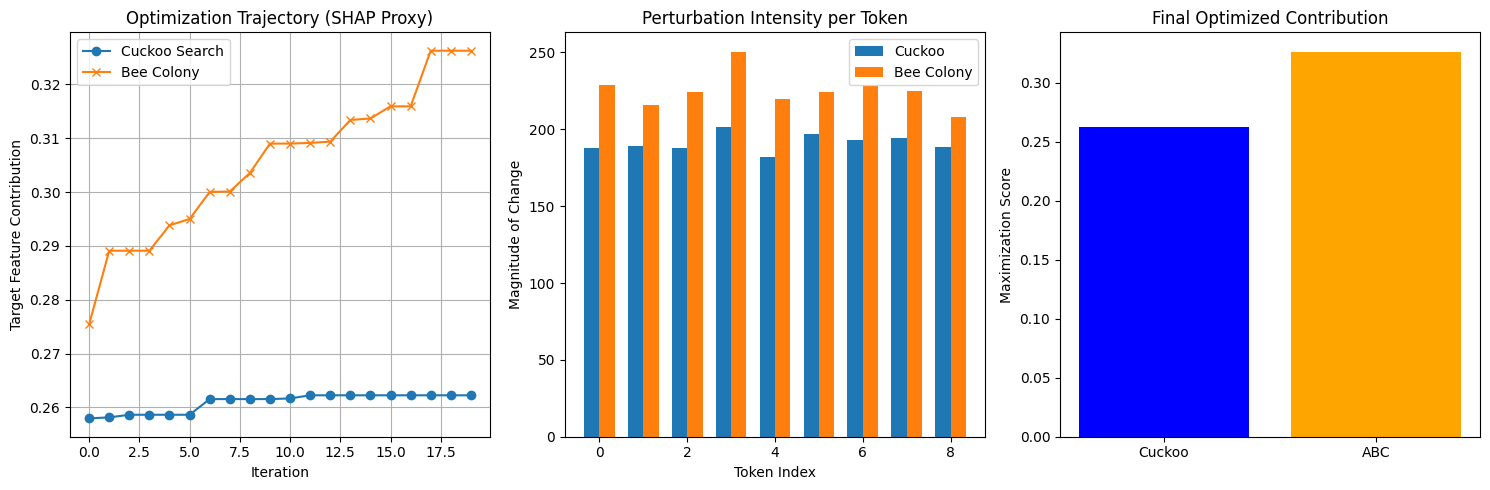

In [25]:
# --- Visualization ---
plt.figure(figsize=(15, 5))

# 1. SHAP Value Trajectory
plt.subplot(1, 3, 1)
plt.plot(cs_history, label="Cuckoo Search", marker='o')
plt.plot(abc_history, label="Bee Colony", marker='x')
plt.title("Optimization Trajectory (SHAP Proxy)")
plt.xlabel("Iteration")
plt.ylabel("Target Feature Contribution")
plt.legend()
plt.grid(True)

# 2. Simulated Feature Importance Changes
# Compare mean noise injected by both algorithms
plt.subplot(1, 3, 2)
# Reshape best vectors back to (Seq_len, Hidden_dim) and sum magnitude per token
cs_impact = np.sum(np.abs(best_perturbation_cs.reshape(optimizer_obj.shape)), axis=2).flatten()
abc_impact = np.sum(np.abs(best_perturbation_abc.reshape(optimizer_obj.shape)), axis=2).flatten()

indices = np.arange(len(cs_impact))
width = 0.35
plt.bar(indices - width/2, cs_impact, width, label='Cuckoo')
plt.bar(indices + width/2, abc_impact, width, label='Bee Colony')
plt.title("Perturbation Intensity per Token")
plt.xlabel("Token Index")
plt.ylabel("Magnitude of Change")
plt.legend()

plt.subplot(1, 3, 3)
# Base probability
base_probs = optimizer_obj.model_prediction_proxy([target_text])[0]
gains = [cs_history[-1], abc_history[-1]]
algs = ['Cuckoo', 'ABC']
plt.bar(algs, gains, color=['blue', 'orange'])
plt.title("Final Optimized Contribution")
plt.ylabel("Maximization Score")

plt.tight_layout()
plt.show()

# **XAI Optimization: LIME**

In [ ]:
def lime_fidelity(config, texts):
    num_samples = int(config['num_samples'])
    kernel_width = float(config['kernel_width'])

    scores = []
    for t in texts:
        exp = lime_explainer.explain_instance(
            t,
            predict_proba,
            num_samples=num_samples,
            kernel_width=kernel_width
        )
        lime_pred = exp.predict_proba
        true_pred = predict_proba([t])[0]
        fid = 1.0 - mean_squared_error(true_pred, lime_pred)
        scores.append(fid)

    return float(np.mean(scores))

def lime_cost(config, texts):
    return -lime_fidelity(config, texts)  # minimization

In [ ]:
# Bat Algorithm for LIME

def random_lime_cfg(bounds):
    cfg = {}
    for k, (low, high) in bounds.items():
        cfg[k] = float(random.uniform(low, high))
    return cfg

def clip_lime_cfg(cfg, bounds):
    new_cfg = {}
    for k, v in cfg.items():
        low, high = bounds[k]
        if k == 'num_samples':
            new_cfg[k] = int(np.clip(v, low, high))
        else:
            new_cfg[k] = float(np.clip(v, low, high))
    return new_cfg

def bat_optimize_lime(bounds, texts, n_bats=3, n_iter=3):
    print("\nStart Bat (LIME)")

    keys = list(bounds.keys())
    positions = [random_lime_cfg(bounds) for _ in range(n_bats)]
    velocities = [np.zeros(len(keys)) for _ in range(n_bats)]
    fitness = []

    for i in range(n_bats):
        positions[i] = clip_lime_cfg(positions[i], bounds)
        f = lime_cost(positions[i], texts)
        fitness.append(f)
        print(f"init bat {i+1}: cost = {f:.4f}")

    best_idx = int(np.argmin(fitness))
    best_pos = copy.deepcopy(positions[best_idx])
    best_fit = fitness[best_idx]
    best_history = [best_fit]

    for it in range(n_iter):
        print(f"\nBat iter {it+1}")
        for i in range(n_bats):
            for idx, k in enumerate(keys):
                velocities[i][idx] += random.uniform(-1, 1)
                positions[i][k] += velocities[i][idx]

            positions[i] = clip_lime_cfg(positions[i], bounds)
            f = lime_cost(positions[i], texts)
            if f < fitness[i]:
                fitness[i] = f

            if f < best_fit:
                best_fit = f
                best_pos = copy.deepcopy(positions[i])

        best_history.append(best_fit)
        print(f"best cost so far = {best_fit:.4f}")

    print("\nBat done")
    print("best LIME cfg:", best_pos)
    print("best fidelity:", -best_fit)

    plt.figure()
    plt.plot([-c for c in best_history], marker='o')
    plt.title("Bat LIME fidelity")
    plt.xlabel("iteration")
    plt.ylabel("fidelity")
    plt.grid(True)
    plt.show()

    return best_pos, -best_fit, best_history

lime_bounds = {
    'num_samples': (500, 2000),
    'kernel_width': (0.3, 2.0)
}

bat_best_cfg, bat_best_fid, bat_hist = bat_optimize_lime(
    lime_bounds,
    val_texts_sample,
    n_bats=3,
    n_iter=3
)

In [ ]:
# Flower Pollination for LIME

def flower_optimize_lime(bounds, texts, n_flowers=3, n_iter=3, p=0.8):
    print("Start Flower (LIME)")

    keys = list(bounds.keys())
    flowers = [random_lime_cfg(bounds) for _ in range(n_flowers)]
    fitness = []

    for i in range(n_flowers):
        flowers[i] = clip_lime_cfg(flowers[i], bounds)
        f = lime_cost(flowers[i], texts)
        fitness.append(f)
        print(f"init flower {i+1}: cost = {f:.4f}")

    best_idx = int(np.argmin(fitness))
    best = copy.deepcopy(flowers[best_idx])
    best_fit = fitness[best_idx]
    best_history = [best_fit]

    for it in range(n_iter):
        print(f"\nFlower iter {it+1}")
        for i in range(n_flowers):
            new = {}
            if random.random() < p:
                # move towards best
                for k in keys:
                    step = random.uniform(-1, 1)
                    new[k] = flowers[i][k] + step * (best[k] - flowers[i][k])
            else:
                j, k_idx = random.sample(range(n_flowers), 2)
                for k in keys:
                    eps = random.random()
                    new[k] = flowers[i][k] + eps * (flowers[j][k] - flowers[k_idx][k])

            new = clip_lime_cfg(new, bounds)
            f = lime_cost(new, texts)

            if f < fitness[i]:
                flowers[i] = new
                fitness[i] = f
                if f < best_fit:
                    best_fit = f
                    best = copy.deepcopy(new)

        best_history.append(best_fit)
        print(f"best cost so far = {best_fit:.4f}")

    print("\nFlower done")
    print("best LIME cfg:", best)
    print("best fidelity:", -best_fit)

    plt.figure()
    plt.plot([-c for c in best_history], marker='o')
    plt.title("Flower LIME fidelity")
    plt.xlabel("iteration")
    plt.ylabel("fidelity")
    plt.grid(True)
    plt.show()

    return best, -best_fit, best_history


flower_best_cfg, flower_best_fid, flower_hist = flower_optimize_lime(
    lime_bounds,
    val_texts_sample,
    n_flowers=3,
    n_iter=3
)